In [1]:
import os
import tarfile
from six.moves import urllib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# using .info() to get total # of rows, each attributes type and number of non-null values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# Generating test/training sets

In [5]:
# looking at 'ocean_proximity' feature.  Look at what categories exist and how many districts belong to each category
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# looking at the other features
# percentiles - ex. 25% of the districts have a housing_median_age lower than 18, while 50% are lower than 29 and 75%
#                   are lower than 37. 
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


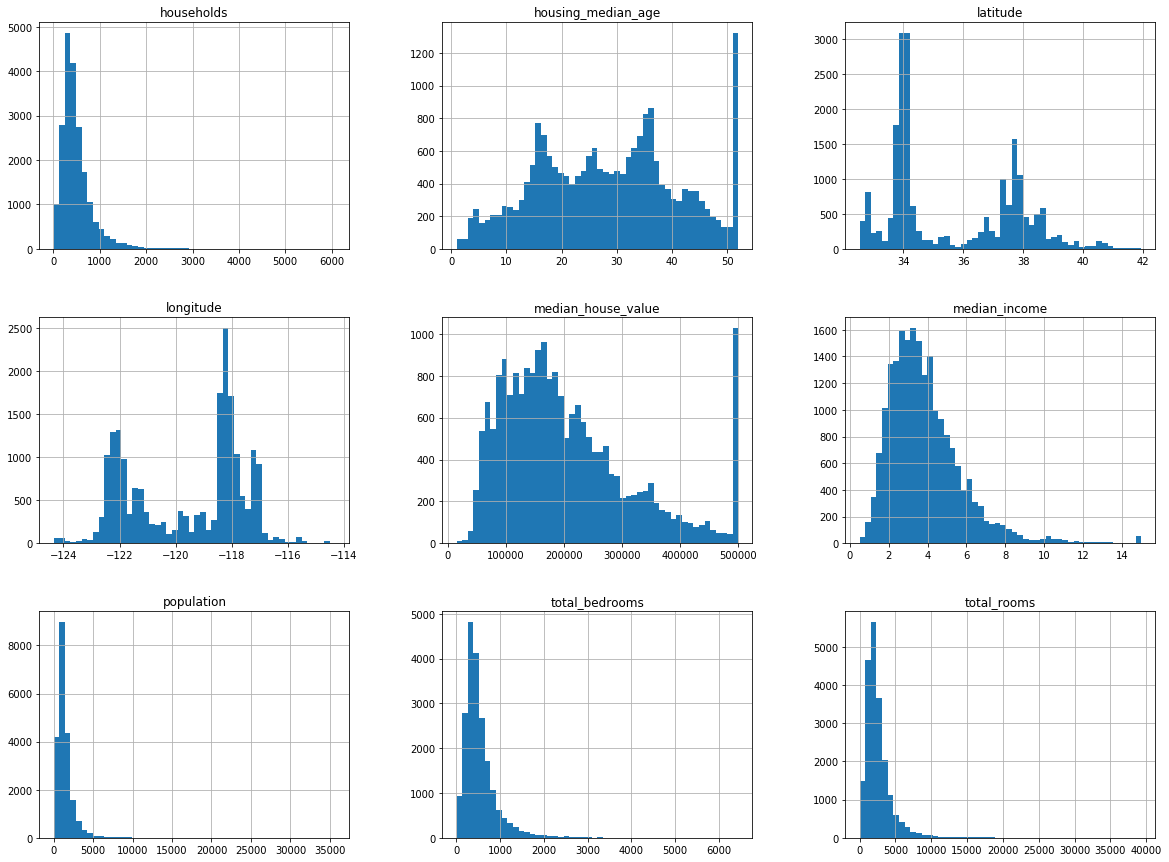

In [7]:
# plotting histogram for each numerical feature. #tail heavy, using logarithm 
housing.hist(bins=50, figsize=(20,15))
plt.show()


In [8]:
# create function to shuffle the data and split into test/train set
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [9]:
#splitting the data 
train_set, test_set = split_train_test(housing, 0.2)

In [10]:
print(len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


In [11]:
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

In [12]:
# stratified sampling
# create income category attribute by dividing the median by 1.5 (to limit # of income categories) and round up
# to have discrete categories, and then merge all the categories greater than 5 into category 5.

housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)

In [13]:
# now perform stratified sampling based on income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:
housing['income_cat'].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [15]:
# remove income_cat attribute so data is back to original state.
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

# Discover/Visualize the Data 

In [16]:
# make a copy of training set so we don't effect the original set
housing = strat_train_set.copy()

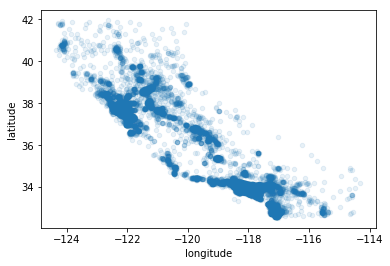

In [17]:
# plotting the longitude and latitude
# setting alpha to 0.1 will show the places where there is a high density of data
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.1)

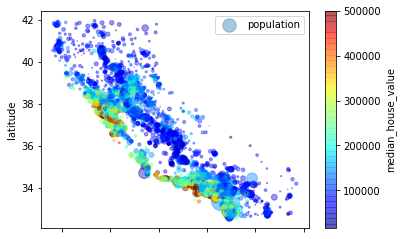

In [18]:
# radius of each circle represents the districts population (s), color represents price (c). 
# using a predefined color map (cmap) called jet, which ranges from blue (low) to red (high)

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population',
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [19]:
# since dataset isn't too large, we can compute the standard correlation coefficient between every pair of features
# using the corr() method

corr_matrix = housing.corr()

In [20]:
# now lets look at how much each feature is correlated with the median house value
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110cbd6d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1114800b8>]], dtype=object)

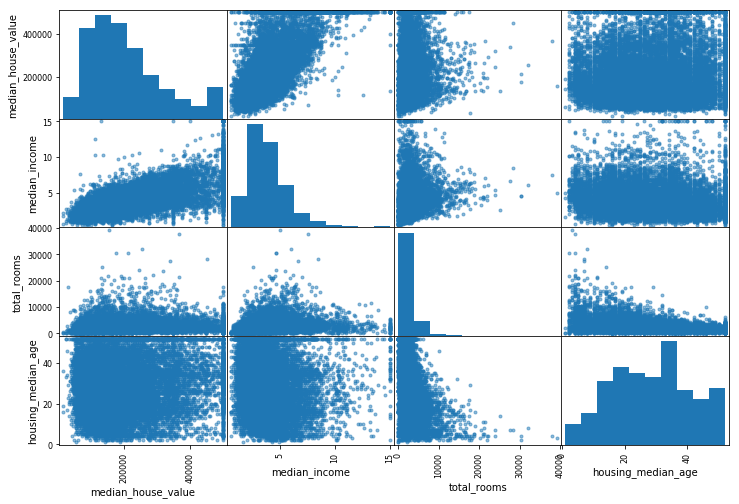

In [21]:
# using pandas scatter_matrix we can plot the relationship between features.  Focusing on a few:
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12,8))

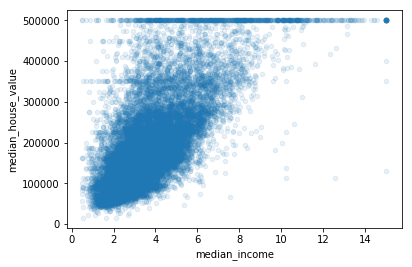

In [22]:
# most promising feature to predict the median house value is the median income, zooming in on the corr. plot

housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [23]:
# trying out various feature combinations. for ex. instead of total rooms per district, calculate total rooms per 
# household. Or instead of total bedrooms, total bedrooms w.r.t total rooms etc.

housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [24]:
# now looking at the new corr matrix
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare Data for ML Algorithms

### Writing functions to prepare data is good for several reasons

- will allow you to reproduce these transformations easily on any dataset.
- gradually build a library of transformation functions that we can resuse in future projects
- we can use these functions in our live system to transform the new data before feeding it to your algo's

In [25]:
# clean training set and seperate the predictors and labels.
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [26]:
# since total_bedrooms has missing values, we will fill it with the Imputer instance. 
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

In [27]:
# since median can only be computer on numerical features, we need to create a copy of the data without the text feat.
housing_num = housing.drop('ocean_proximity', axis=1)

# now we can fit the Imputer instance, and calc. the median of each attribute and store the result in its statistics_
# instance variable
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [28]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [29]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [30]:
# now we use the 'trained' imputer to transform the training set by replacing values by the learned medians
X = imputer.transform(housing_num)

In [31]:
# result is in a numpy array, we can transform it back to pd dataframe by:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [32]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


### Handling Text and Categorical Attributes

In [33]:
# we need to convert the text labels to numbers, so we use LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [34]:
# look at the mapping that this encoder has learned using the classes_ attribute (<1H Ocean => 0 etc..)

print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [35]:
# probably a better idea is to one-hot encode the data, so we will use OneHotEncoder from Scikit-Learn
# ***Note*** fit_transform() expects a 2D array, so we need to reshape it

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [36]:
# Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you
# have categorical attributes with thousands of categories. After one-hot encoding we get a matrix with
# thousands of columns, and the matrix is full of zeros except for one 1 per row. Using up tons of memory
# mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the
# nonzero elements. You can use it mostly like a normal 2D array,
# 19 but if you really want to convert it to a
# (dense) NumPy array, just call the toarray() method:

housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [37]:
# we can transform text categories -> integer categories, then integer categories -> one-hot vectors in one shot 
# using LabelBinarizer class
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

- Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform(). You can get the last one for free by simply adding TransformerMixin as a base class. Also, if you add BaseEstimator as a base class (and avoid *args and * *kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning.

- the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Feature Scaling

- Min-Max Scaling - values are shifted and rescaled so that they range between 0 and 1.  **(X-min)/(Max-Min)**
- Standardization - the values are transformed so that the standardized value has zero mean and unit variance. This does not limit the range of values (which may be a problem for some algorithms who do better with a range of 0-1.  Standardization is also much less affected by outliers.  **(X-mean)/(variance)**

- note - fit the scalers to the training data only, not the full dataset.  Then we can use them to transform the training set and test set (new data)

In [40]:
# since multiple data transformations need to applied in the right order, we can Scikit-Learn Pipeline class.
# a pipeline for the numerical attritubes.

# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# num_pipeline = Pipeline([
#     ('imputer', Imputer(strategy='median')),
#     ('attribs_adder', CombinedAttributesAdder()),
#     ('std_scaler', StandardScaler()),
# ])
# housing_num_tr = num_pipeline.fit_transform(housing_num)


# ******* moved below *******

- The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method). The names can be anything you like.
- When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method.  The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in sequence (it also has a fit_transform method that we could have used instead of calling fit() and then transform()).

- You now have a pipeline for numerical values, and you also need to apply the LabelBinarizer on the categorical values: how can you join these transformations into a single pipeline? Scikit-Learn provides a FeatureUnion class for this. You give it a list of transformers (which can be entire transformer pipelines), and when its transform() method is called it runs each transformer’s transform() method in parallel, waits for their output, and then concatenates them and returns the result (and of course calling its fit() method calls all each transformer’s fit() method)

In [42]:
# since each pipeline starts with a selector transformer, it transforms the data by selecting the desired attributes
# (numerical or categorical), dropping the rest, and converting the resulting DataFrame to a numpy array.  Since scikit
# cannot handle pandas DataFrames we can deal with that as such: 
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

#running the whole pipeline 

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [46]:
housing_prepared.shape

(16512, 16)

# Selecting/Training Models

### Linear Regression

In [47]:
# trying a linear regression model first
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
# lets try it out on a few samples
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
# remember to transform the data that we're testing on
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:\t', lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210668.  317776.  210896.   59260.  189756.]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


- now lets see what the RMSE is for the whole training set

In [53]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.229049814981

- most districts median_housing_values range between \$120,000 and \$265,000 with a typical prediction error of \$68,628 is not good.  
- since the model is underfitting, we can either add more features or try a more complex model


### Decision Tree Regressor

In [54]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

- the model has clearly overfit the data which is done from using all of the training set instead of having a validation set


### Cross-Validation
- we could use the train_test_split again for a validation set or use k-fold crossvalidation
- **k-fold cross-validation** randomly splits the training set into 10 (k) distinct subsets (folds) and then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds.  This will give an array containing 10 evaluation scores

- note: Scikit-Learn cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes scores before calculating the square root.

In [58]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [59]:
# looing at the results
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard Deviation: ', scores.std())

display_scores(tree_rmse_scores)

Scores:  [ 69846.47958693  68447.33618128  71795.19981315  68040.33630979
  70849.80326932  75262.46674288  69433.15721481  70941.42133037
  76869.21703046  71454.75677874]
Mean:  71294.0174258
Standard Deviation:  2677.28058288


- The Decision Tree is doing worse than the Linear Regressor.  The score is approximately 71,295 $\pm$ 2677.

In [60]:
# lets check the linear regressor with cross validation
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [ 66755.93082508  66960.78231113  70337.66221381  74773.51159358
  68031.13388938  71206.29303154  64966.43700878  68263.59244197
  71550.86526138  67672.135766  ]
Mean:  69051.8344343
Standard Deviation:  2741.87267138


- the linear regressor has avg error of 69051 $\pm$ 2741. it looks like the Decision Tree model is overfitting very badly.

### Random Forest Regressor
- Random Forests work by training many DT on random subsets of the features, then averaging out their predictions.  

In [62]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [ 52998.18322229  50333.0688691   50740.99752317  54033.68388026
  52106.55752366  55759.48084338  51366.57948232  50867.15272816
  56428.68807479  52728.42282807]
Mean:  52736.2814975
Standard Deviation:  2001.2090135


- since it is good to test many models it is good to save all of our models

In [63]:
# using this code 
# from sklearn.externals import joblib
# joblib.dump(my_model, "my_model.pkl")
# # and later...
# my_model_loaded = joblib.load("my_model.pkl")

# Fine-Tune Parameters

### Grid Search
- Using GridSearchCV to search through all of the combinations of hyperparameters using cross-validation.  

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [60, 80, 100], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [60, 80, 100]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

- **param_grid** tells scikit-learn to first evaluate 3x4=12 combinations of n_estimators and max_features hyperparameters values specified in the first dict.
- then try all 2x3=6 combinations of hyperparameters values in the second dict, but this time with the bootstrap hyperparameter set to False instead of True.
- the gridsearch will explore 12+6=18 combinations of RandomForestRegressor hyperparameter values and it will train each model five times (k=5 for CV)

In [72]:
# finding out the best combination of parameters 
grid_search.best_params_

{'max_features': 6, 'n_estimators': 100}

In [73]:
#getting the best estimator directly
grid_search.best_estimator_


# note - if refit=True(by default) then once it finds the best estimator using cross-validation, it retrains on the
#      the whole training set.

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

- finding out the importance scores and displaying them next to their feature name

In [75]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33655286525931349, 'median_income'),
 (0.15829465222074035, 'INLAND'),
 (0.10715207087592045, 'pop_per_hhold'),
 (0.073130699548066225, 'longitude'),
 (0.068734900707862132, 'latitude'),
 (0.064727097362068498, 'bedrooms_per_room'),
 (0.06234999858888788, 'rooms_per_hhold'),
 (0.042347651863373824, 'housing_median_age'),
 (0.01770154202607814, 'total_rooms'),
 (0.017600527831618931, 'population'),
 (0.016687184063716817, 'households'),
 (0.016580675032421076, 'total_bedrooms'),
 (0.011489888084305167, '<1H OCEAN'),
 (0.0039929567840735498, 'NEAR OCEAN'),
 (0.002582265613495731, 'NEAR BAY'),
 (7.502413805763369e-05, 'ISLAND')]

# Evaluate System on Test Set

In [76]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [77]:
print(final_rmse)

47098.8038976
